# Food.com

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
import numpy as np
import seaborn as sns

### Datasets

In [2]:
recipes_df = pd.read_csv('./data/RAW_recipes.csv')
ratings_df = pd.read_csv('./data/RAW_interactions.csv')

## Ratings 

In [3]:
display(ratings_df)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...


### Weighted Ratings

In [4]:
weighted_ratings_df = ratings_df.copy()
weighted_ratings_df = weighted_ratings_df.drop(['date', 'review'], axis=1)
weighted_ratings_df = weighted_ratings_df.groupby(['recipe_id', 'rating']).count()
weighted_ratings_df = weighted_ratings_df.rename(columns={"user_id": "users"})
weighted_ratings_df.reset_index(inplace=True)
display(weighted_ratings_df)

,recipe_id,rating,users
0,38,4,3
1,38,5,1
2,39,3,1
3,40,1,1
4,40,4,2
...,...,...,...
367682,537459,5,1
367683,537485,5,1
367684,537543,0,1
367685,537671,0,1


### Distribution of recipes ratings

<AxesSubplot:>

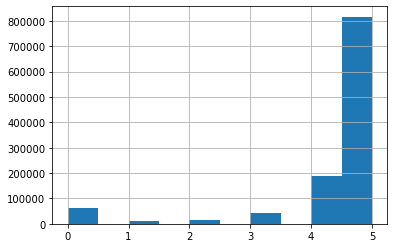

In [5]:
weighted_ratings_df['rating'].hist(histtype='bar', weights=weighted_ratings_df['users'])

### Average Ratings

In [6]:
average_ratings_df = ratings_df.copy()
average_ratings_df = average_ratings_df[['recipe_id', 'rating']]
average_ratings_df = average_ratings_df.groupby('recipe_id').agg({'rating':'mean'})
average_ratings_df.reset_index(inplace=True)
display(average_ratings_df)

,recipe_id,rating
0,38,4.250000
1,39,3.000000
2,40,4.333333
3,41,4.500000
4,43,1.000000
...,...,...
231632,537459,5.000000
231633,537485,5.000000
231634,537543,0.000000
231635,537671,0.000000


## Recipes

In [7]:
display(recipes_df)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8
...,...,...,...,...,...,...,...,...,...,...,...,...
231632,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22
231633,zydeco spice mix,493372,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"['paprika', 'salt', 'garlic powder', 'onion po...",13
231634,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",8
231635,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh...",10


### Exploding the dataset

In [8]:
raw_recipes_df = recipes_df.copy()
raw_recipes_df = raw_recipes_df.rename({"id":"recipe_id"}, axis=1)
merged_recipes_df = pd.merge(raw_recipes_df, average_ratings_df, on="recipe_id")
display(merged_recipes_df)

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,5.0
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,3.5
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,4.0
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,4.5
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231632,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22,5.0
231633,zydeco spice mix,493372,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"['paprika', 'salt', 'garlic powder', 'onion po...",13,5.0
231634,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",8,5.0
231635,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh...",10,1.0


In [9]:
merged_recipes_exploded = merged_recipes_df.copy()
merged_recipes_exploded['ingredients'] = merged_recipes_exploded['ingredients'].apply(literal_eval) 
merged_recipes_exploded = merged_recipes_exploded.explode('ingredients')
display(merged_recipes_exploded)

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,winter squash,7,5.0
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,mexican seasoning,7,5.0
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,mixed spice,7,5.0
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,honey,7,5.0
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,butter,7,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231636,cookies by design sugar shortbread cookies,298509,20,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[174.9, 14.0, 33.0, 4.0, 4.0, 11.0, 6.0]",5,"['whip sugar and shortening in a large bowl , ...","i've heard of the 'cookies by design' company,...",eggs,7,2.0
231636,cookies by design sugar shortbread cookies,298509,20,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[174.9, 14.0, 33.0, 4.0, 4.0, 11.0, 6.0]",5,"['whip sugar and shortening in a large bowl , ...","i've heard of the 'cookies by design' company,...",flour,7,2.0
231636,cookies by design sugar shortbread cookies,298509,20,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[174.9, 14.0, 33.0, 4.0, 4.0, 11.0, 6.0]",5,"['whip sugar and shortening in a large bowl , ...","i've heard of the 'cookies by design' company,...",cream of tartar,7,2.0
231636,cookies by design sugar shortbread cookies,298509,20,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[174.9, 14.0, 33.0, 4.0, 4.0, 11.0, 6.0]",5,"['whip sugar and shortening in a large bowl , ...","i've heard of the 'cookies by design' company,...",baking soda,7,2.0


## Ingredients Stats

In [10]:
exploded_df = merged_recipes_exploded.copy()
ingredient_group_df = exploded_df.groupby('ingredients').agg(recipe_count=('recipe_id', 'count'), \
                                                             rating_count=('rating', 'count'), \
                                                             rating_mean=('rating', 'mean'))
ingredient_group_df['frequency'] = ingredient_group_df['recipe_count'] / recipes_df.shape[0]
ingredient_group_df.reset_index(inplace=True)
display(ingredient_group_df)

,ingredients,recipe_count,rating_count,rating_mean,frequency
0,1% fat buttermilk,24,24,4.094461,0.000104
1,1% fat cottage cheese,32,32,4.241909,0.000138
2,1% low-fat chocolate milk,2,2,4.000000,0.000009
3,1% low-fat milk,472,472,4.351697,0.002038
4,10 bean soup mix,2,2,4.750000,0.000009
...,...,...,...,...,...
14937,zoom quick hot cereal,1,1,5.000000,0.000004
14938,zucchini,4591,4591,4.364116,0.019820
14939,zucchini with italian-style tomato sauce,3,3,4.722222,0.000013
14940,zwieback toast,5,5,3.500000,0.000022


### Ingredient Score

In [11]:
# Count the used ingredients
ingredients_stat_df = ingredient_group_df.copy()
ingredients_stat_df = ingredients_stat_df.sort_values(by=['frequency'], ascending=False, axis=0)
display(ingredients_stat_df)

,ingredients,recipe_count,rating_count,rating_mean,frequency
11751,salt,85746,85746,4.315016,0.370174
1651,butter,54975,54975,4.337297,0.237333
12908,sugar,44535,44535,4.290884,0.192262
9414,onion,39065,39065,4.335771,0.168647
14316,water,34914,34914,4.248465,0.150727
...,...,...,...,...,...
8200,low-fat tomato soup,1,1,2.000000,0.000004
8197,low-fat sugar-free frozen vanilla yogurt,1,1,5.000000,0.000004
8194,low-fat spicy chicken sausage,1,1,1.000000,0.000004
8191,low-fat soft cheese with chives and onions,1,1,5.000000,0.000004


### Frequency of ingredients used

In [12]:
frequency_df = ingredients_stat_df.copy()
frequency_df = frequency_df[['ingredients','frequency']]
display(frequency_df)

,ingredients,frequency
11751,salt,0.370174
1651,butter,0.237333
12908,sugar,0.192262
9414,onion,0.168647
14316,water,0.150727
...,...,...
8200,low-fat tomato soup,0.000004
8197,low-fat sugar-free frozen vanilla yogurt,0.000004
8194,low-fat spicy chicken sausage,0.000004
8191,low-fat soft cheese with chives and onions,0.000004


### Top 10 popular Ingredients in the Dataset

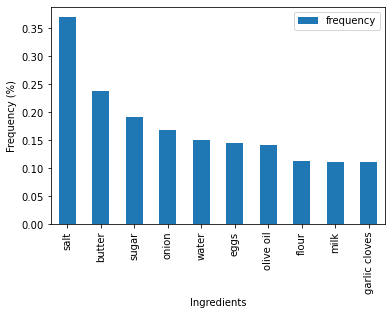

In [13]:
frequency_chart = frequency_df.iloc[0:10]
ax = frequency_chart.plot.bar(x='ingredients', xlabel='Ingredients', y='frequency', ylabel="Frequency (%)")

## Cooking Time

### Distribution of recipes by minutes of preparation

In [15]:
time_distribution_df = recipes_df.copy()
time_distribution_df['time'] = np.where(recipes_df['minutes'] % 30 == 0 , (recipes_df['minutes'] / 30).astype(int) * 30, ((recipes_df['minutes'] / 30 ).astype(int) + 1) * 30) 
time_distribution_df = time_distribution_df[['time','id']]
time_distribution_df = time_distribution_df.groupby('time').count()
time_distribution_df.reset_index(inplace=True)
time_distribution_df = time_distribution_df.rename({'id':'recipe_count'}, axis=1)
display(time_distribution_df)

,time,recipe_count
0,0,1094
1,30,97959
2,60,70077
3,90,29071
4,120,7612
...,...,...
216,259230,1
217,259260,1
218,288000,1
219,1051200,1


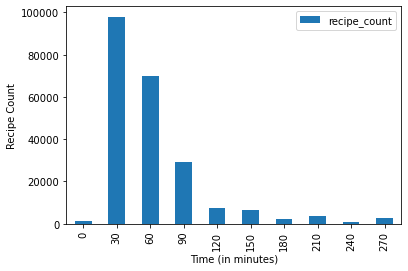

In [16]:
time_distribution_graph = time_distribution_df.iloc[0:10]
ax = time_distribution_graph.plot.bar(x='time', xlabel='Time (in minutes)', y='recipe_count', ylabel="Recipe Count")

## Correlation 

In [17]:
corr_df = merged_recipes_df.copy()
corr_df = corr_df[['recipe_id','minutes','n_ingredients','n_steps','rating']]
corr_df.set_index('recipe_id')
display(corr_df)

,recipe_id,minutes,n_ingredients,n_steps,rating
0,137739,55,7,11,5.0
1,31490,30,6,9,3.5
2,112140,130,13,6,4.0
3,59389,45,11,11,4.5
4,44061,190,8,5,5.0
...,...,...,...,...,...
231632,486161,60,22,7,5.0
231633,493372,5,13,1,5.0
231634,308080,40,8,7,5.0
231635,298512,29,10,9,1.0


### Correlation between minutes and ratings

In [18]:
correlation = corr_df['rating'].corr(corr_df['minutes'])
print(correlation)

0.0008124398145594486


### Correlation matrix

<AxesSubplot:>

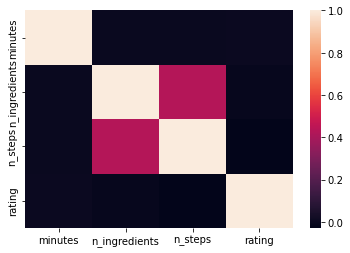

In [19]:
heatmap_df = corr_df.copy()
heatmap_df = heatmap_df.drop('recipe_id', axis=1)
sns.heatmap(heatmap_df.corr())

### Correlation between Ingredients

In [20]:
# 
start = 0
end = start+20
subset_count_ingredients = ingredient_group_df.iloc[start:end]

ingredients_subset = pd.merge(merged_recipes_exploded, subset_count_ingredients, how='inner', on=['ingredients'])
# ingredients_subset = ingredients_subset['ingredients']
ingredients_dummies = pd.get_dummies(ingredients_subset.ingredients)
display(ingredients_dummies)

,1% fat buttermilk,1% fat cottage cheese,1% low-fat chocolate milk,1% low-fat milk,10 bean soup mix,10 inch low-fat flour tortillas,"10"" pie crust",10% cream,10-inch deep dish pie crust,10-inch baked pie shells,10-inch corn tortillas,10-inch flour tortilla,10-inch flour tortillas,10-inch pie shell,10-inch sun-dried tomato tortillas,10-inch unbaked deep-dish pie shell,10-inch whole wheat tortillas,10-minute herb stuffing mix,10-minute success rice,100 proof vodka
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
621,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
622,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
623,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


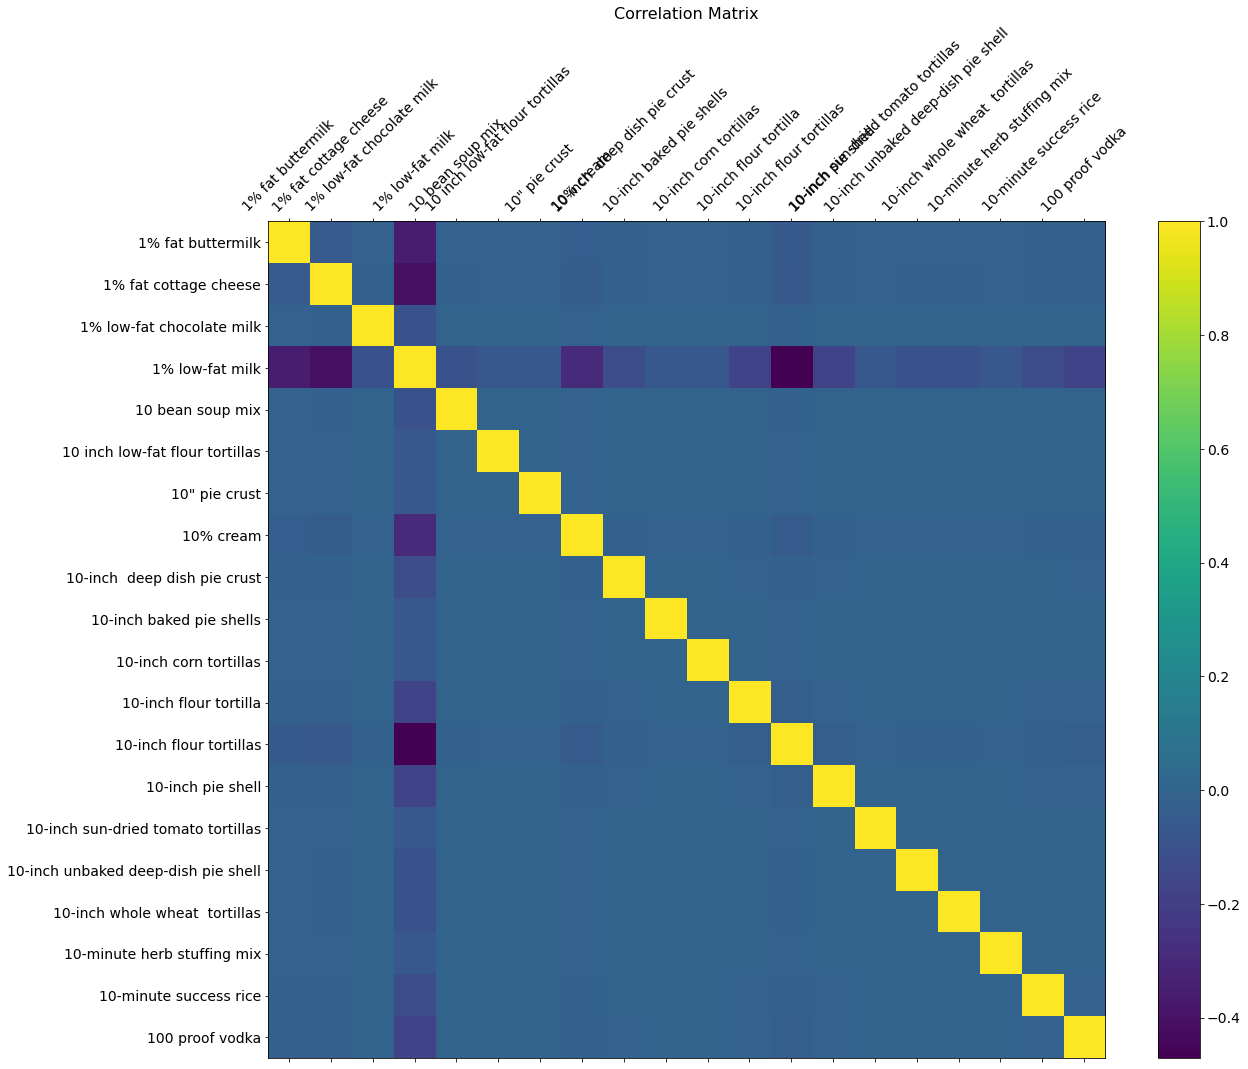

In [21]:
df = ingredients_dummies.copy()
# df = df.sample(n=20, axis='columns')
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

## Distribution of no of ingredients per recipe 

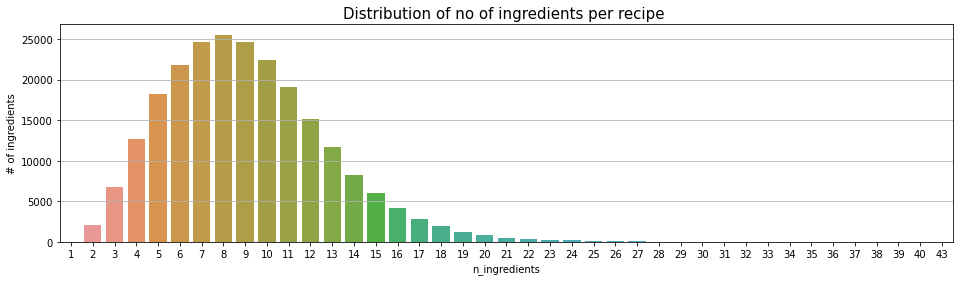

In [22]:
distribution_df = recipes_df.groupby(['n_ingredients']).size().reset_index(name='# of ingredients')
distribution_df.shape

fig = plt.figure(figsize=(16, 4))
plt.grid()
plt.title('Distribution of no of ingredients per recipe ', fontsize=15)


line_chart = sns.barplot(x='n_ingredients', y='# of ingredients', data=distribution_df)
# line_chart.set(ylim=(0, distribution_df['# of ingredients'].max()))

## Average rating per number of ingredients

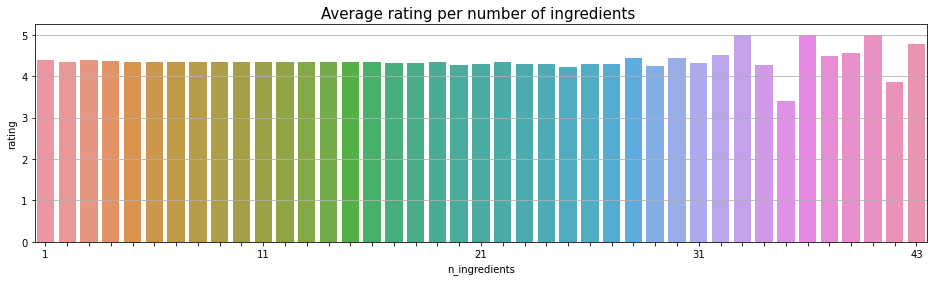

In [23]:
average_rating_per_no_ingredients = ratings_df.groupby(['recipe_id'], as_index=False)['rating'].mean()
average_rating_per_no_ingredients.rename(columns={'recipe_id': 'id'}, inplace=True)

average_rating_per_no_ingredients_m = recipes_df.merge(average_rating_per_no_ingredients, on='id')
average_rating_per_no_ingredients_m

fig = plt.figure(figsize=(16, 4))
plt.grid()
plt.title('Average rating per number of ingredients ', fontsize=15)


line_chart = sns.barplot(x='n_ingredients', y='rating', data=average_rating_per_no_ingredients_m, ci=None)

for ind, label in enumerate(line_chart.get_xticklabels()):
    if ind % 10 == 0:  # every 9th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
# line_chart.set(ylim=(0, distribution_df['rating'].max()))

## Average number of nutritional elements, for every rating.

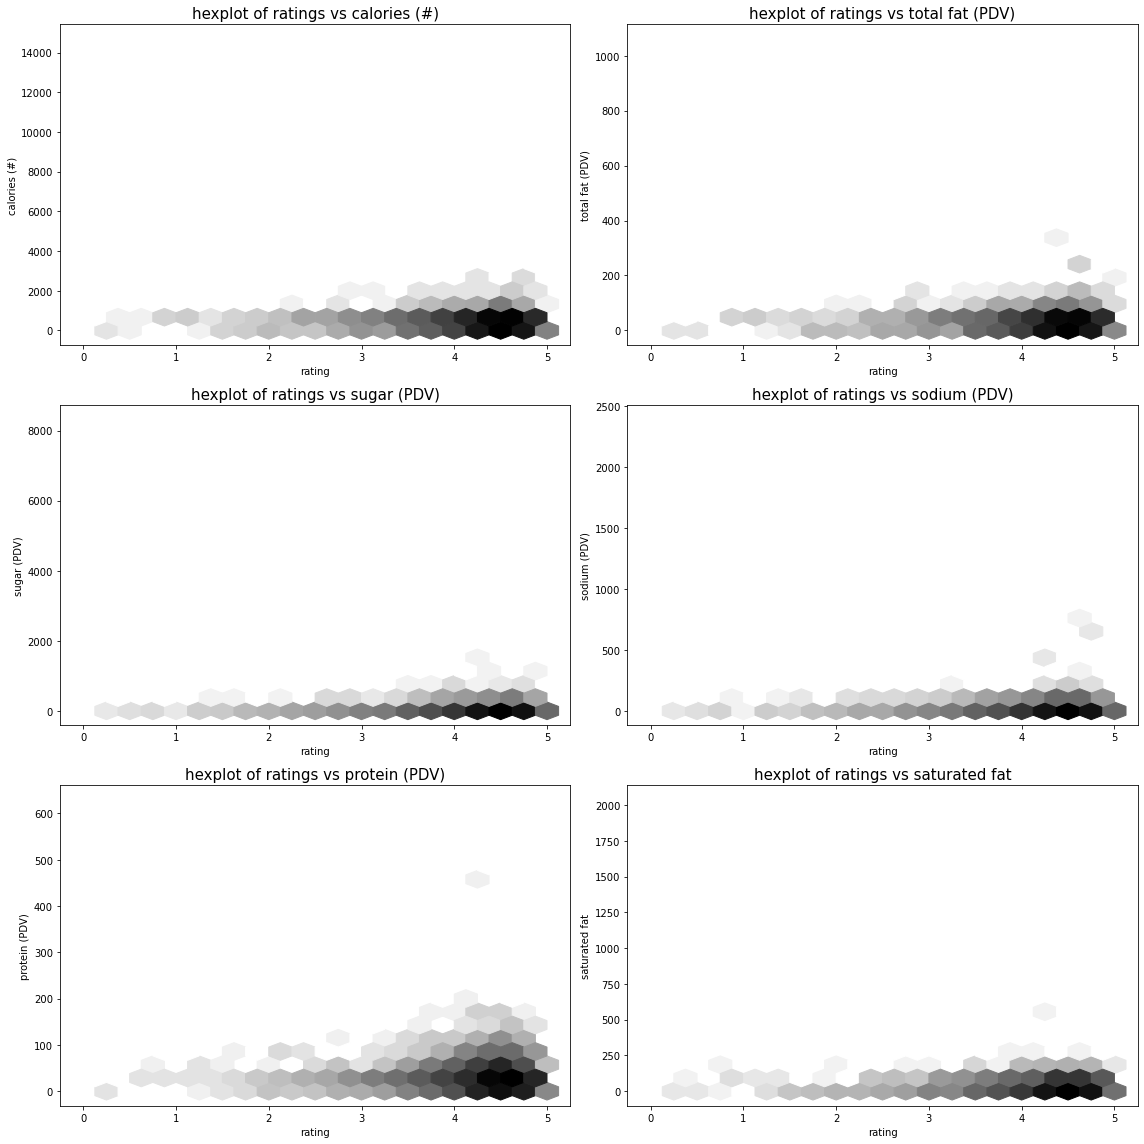

In [24]:
average_rating_per_no_ingredients_df = average_rating_per_no_ingredients_m.copy()
average_rating_per_no_ingredients_df['nutrition'] = average_rating_per_no_ingredients_df['nutrition'].apply(literal_eval)
average_rating_per_no_ingredients_m_exploded = average_rating_per_no_ingredients_df.explode("nutrition")

nutrition_info = ['calories (#)', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat']
nutrition_df = pd.DataFrame()
all_nutrition_df = pd.DataFrame()

plt.figure(figsize=(16, 16))

for index, nutrition in enumerate(nutrition_info):
    nutrition_df = average_rating_per_no_ingredients_m_exploded.groupby('id').nth(index)
    nutrition_df = nutrition_df[['rating', 'nutrition']]
    nutrition_df.astype(float)
    nutrition_df = nutrition_df.groupby(['rating'])['nutrition'].apply(np.mean).reset_index()
    if('rating' not in list(all_nutrition_df.columns.values)):
        all_nutrition_df['rating'] = nutrition_df['rating']
    all_nutrition_df[nutrition] = nutrition_df['nutrition']
    
    plt.subplot(3, 2, index+1)
    plt.title('hexplot of ratings vs ' + nutrition, fontsize=15)
    hexplot_chart = plt.hexbin(x=all_nutrition_df['rating'], y=all_nutrition_df[nutrition], gridsize=20, bins='log', cmap='Greys')
    plt.xlabel("rating", fontsize=10)
    plt.ylabel(nutrition,fontsize=10) 
    plt.tight_layout()